In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
%cd "/home/volkan/Repos/multi-tier"
from data_analysis.helpers import *

def query_json_db(db_file, parameter_filters):
    with open(db_file, "r") as file:
        db_data = json.load(file)

    matching_entries_dict = {}
    matching_entries_params = []

    for entry_id, entry_data in db_data.items():
        if "parameters" in entry_data:
            parameters = entry_data["parameters"]
            if all(
                (
                    parameters.get(param) in value
                    if isinstance(value, list)
                    else parameters.get(param) == value
                )
                for param, value in parameter_filters.items()
            ):
                matching_entries_dict[entry_id] = entry_data
                matching_entries_params.append(parameters)

    return matching_entries_dict, matching_entries_params

def get_db_and_params(db_file, base_filters, case_filters):
    parameter_filters = deepcopy(base_filters)
    parameter_filters.update(case_filters)
    db, param_sets = query_json_db(db_file, parameter_filters)
    return db, param_sets

def get_data(topology, db_file, base_filters, case_filters, seeds, metric):
    db, param_sets = get_db_and_params(db_file, base_filters, case_filters)
    param_list = dictsToParamSets(param_sets)
    return getDataFieldSumAvgsAcrossSeeds(topology, db, param_list, seeds[0], seeds[1], metric)


/home/volkan/Repos/multi-tier


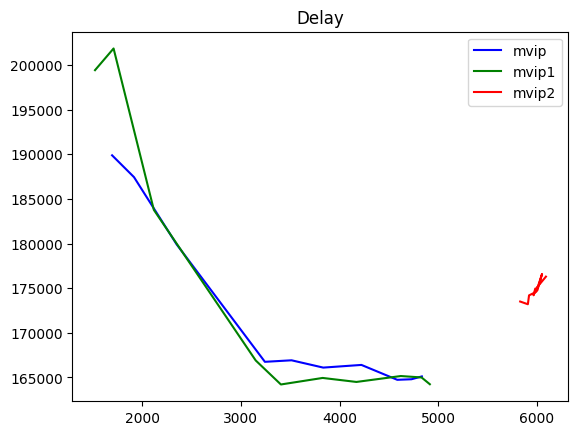

In [12]:
topology = "abilene"

base_filters = {}
seeds = [[1],[1]]

case_filters_list = [
    {
        "cache_pol": "mvip"
    },
    {
        "cache_pol": "mvip1"
    },
    {
        "cache_pol": "mvip2"
    },
]

pw = [0, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
db_file = "sim_outputs/some_abilene_db.json"

delay = []
cost = []
first_tier_hits = []
second_tier_hits = []
first_tier_writes = []
second_tier_writes = []
first_tier_replacements = []
second_tier_replacements = []
first_tier_vp_evictions = []
second_tier_vp_evictions = []
for case_filters in case_filters_list:
    delay.append(get_data(topology, db_file, base_filters, case_filters, seeds, "delay"))
    read_cost = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_read_penalties")
    write_cost = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_write_penalties")
    cost.append(np.sum(read_cost + write_cost, axis=1))
    hits = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_hits")
    first_tier, second_tier = np.hsplit(hits, 2)
    first_tier_hits.append(deepcopy(first_tier))
    second_tier_hits.append(deepcopy(second_tier))
    replacements = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_replacements")
    first_tier, second_tier = np.hsplit(replacements, 2)
    first_tier_replacements.append(deepcopy(first_tier))
    second_tier_replacements.append(deepcopy(second_tier))
    writes = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_writes")
    first_tier, second_tier = np.hsplit(writes, 2)
    first_tier_writes.append(deepcopy(first_tier))
    second_tier_writes.append(deepcopy(second_tier))
    vp_evictions = get_data(topology, db_file, base_filters, case_filters, seeds, "vp_evictions")
    first_tier, second_tier = np.hsplit(vp_evictions, 2)
    first_tier_vp_evictions.append(deepcopy(first_tier))
    second_tier_vp_evictions.append(deepcopy(second_tier))

fig, ax = plt.subplots()

ax.plot(cost[0], delay[0], 'b', label="mvip")
ax.plot(cost[1], delay[1], 'g', label="mvip1")
ax.plot(cost[2], delay[2], 'r', label="mvip2")
ax.set_title("Delay")

ax.legend()